<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Copy_of_inference_open_llama_7b_qlora_uncensored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model inference
## georgesung/open_llama_7b_qlora_uncensored
Tested to work on a T4 GPU in Google Colab (T4 GPU available for free in Colab)

In [15]:
import torch
torch.__version__

'2.0.1+cu118'

In [1]:
!nvidia-smi

Sat Jul 22 11:37:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install -qU transformers langchain accelerate bitsandbytes sentencepiece xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.2 MB/s eta 0:00:00


In [13]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [14]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.21.0
aiohttp                          3.8.4
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bitsandbytes                     0.40.

In [3]:
from transformers import AutoModel, AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig
from transformers import LlamaForCausalLM, LlamaTokenizer
from langchain import PromptTemplate

from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig, pipeline
import torch

import json
import textwrap

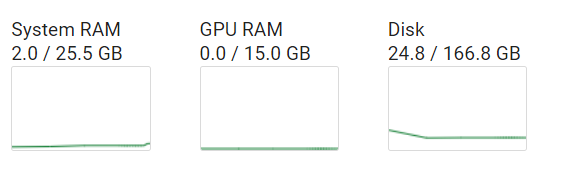

## Load the model

In [4]:
model_id = "georgesung/open_llama_7b_qlora_uncensored"

tokenizer = LlamaTokenizer.from_pretrained(model_id)
model = LlamaForCausalLM.from_pretrained(model_id, device_map="auto", load_in_8bit=True)

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

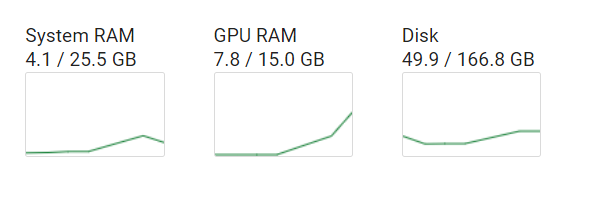

In [8]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
)

## Helper functions

In [9]:
def get_prompt(human_prompt):
    prompt = f"### HUMAN:\n{human_prompt}\n\n### RESPONSE:\n"
    return prompt

def get_response_text(data, wrap_text=True):
    text = data[0]["generated_text"]

    assistant_text_index = text.find('### RESPONSE:')
    if assistant_text_index != -1:
        text = text[assistant_text_index+len('### RESPONSE:'):].strip()

    if wrap_text:
      text = textwrap.fill(text, width=100)

    return text

def get_llm_response(prompt, wrap_text=True):
    raw_output = pipe(get_prompt(prompt))
    text = get_response_text(raw_output, wrap_text=wrap_text)
    torch.cuda.empty_cache()
    return text

## Basic prompts

In [10]:
%%time
prompt = "Who was the first person on the moon?"
print(get_llm_response(prompt))
print("\n--------")

The first person to set foot on the moon was Neil Armstrong, who landed on the lunar surface with
Buzz Aldrin during the Apollo 11 mission in July of 1969.

--------
CPU times: user 10.3 s, sys: 326 ms, total: 10.6 s
Wall time: 13.9 s


In [11]:
%%time
prompt = "Give me a travel itinerary for my vacation to Taiwan."
print(get_llm_response(prompt, wrap_text=False))
print("\n--------")

Day 1: Arrive in Taipei and check into your hotel. Spend the day exploring the city, including visiting the National Chiang Kai-shek Memorial Hall, Longshan Temple, and the Shilin Night Market.

Day 2: Take a day trip to Taroko Gorge National Park, one of the most beautiful natural wonders in Taiwan. Enjoy hiking through the gorge and taking in the stunning views.

Day 3: Head to Tainan, the oldest city in Taiwan, where you can visit the Anping Old Street and the National Museum of History.

Day 4: Travel to Kaohsiung, the second largest city in Taiwan, and spend the day exploring its many attractions, including the Love River, the Pier 2 Art Center, and the Formosa Boulevard.

Day 5: Visit the Sun Moon Lake area, which is known for its scenic beauty and cultural significance. You can take a boat ride on the lake, visit the Seven Star Caves, and explore the nearby temples and shrines.

Day 6: Fly back home with memories of an unforgettable vacation in Taiwan!

--------
CPU times: user 

In [13]:
%%time
prompt = "Give me a travel itinerary for my vacation to Mumbai."
print(get_llm_response(prompt, wrap_text=False))
print("\n--------")

Day 1: Arrive in Mumbai and check-in at your hotel.
Day 2: Spend the day exploring the city's most famous attractions, such as the Gateway of India, Chhatrapati Shivaji Maharaj Terminus (formerly Victoria Terminus), and the Dhobi Ghat.
Day 3: Visit the Elephanta Caves, which are located on an island off the coast of Mumbai. Take a boat ride to reach the caves and explore their ancient Hindu temples.
Day 4: Head out to visit the Hanging Gardens, which offer stunning views of the city from above.
Day 5: Spend the morning visiting the Museum of Art & Photography, which houses a collection of Indian art dating back centuries. Afterwards, head to the Jain Temple, which is one of the oldest and most beautiful temples in the city.
Day 6: Enjoy a day trip to Lonavala, a popular hill station located just outside of Mumbai. Take a cable car ride up to the top of Khandala Fort for panoramic views of the surrounding area.
Day 7: Return to Mumbai and spend the afternoon exploring the markets and ba

In [12]:
%%time
prompt = "Provide a step by step recipe to make Dum Biryani."
print(get_llm_response(prompt, wrap_text=False))
print("\n--------")

1. First, you need to soak basmati rice for at least 30 minutes in water.
2. Then, heat oil in a pan and add cumin seeds. Once they start to sizzle, add onion and garlic paste. Cook until the onions are translucent.
3. Add ginger-garlic paste and cook for another minute or two.
4. Now, add turmeric powder, red chili powder, garam masala, salt, and pepper. Mix well and cook for a few more minutes.
5. Next, add chopped tomatoes and cook until they become soft.
6. After that, add chicken pieces and stir fry them until they are cooked through.
7. Finally, add drained soaked rice and mix everything together.
8. Cover the pan with a lid and let it cook on low heat for about 15-20 minutes.
9. When the biryani is ready, take off the heat and serve hot.

--------
CPU times: user 39.6 s, sys: 0 ns, total: 39.6 s
Wall time: 39.8 s


In [14]:
%%time
prompt_template = f"""Use the following pieces of context to answer the question at the end.

{{context}}

Question: {{question}}
Answer:"""
context = "I decided to use QLoRA as the fine-tuning algorithm, as I want to see what can be accomplished with relatively accessible hardware. I fine-tuned OpenLLaMA-7B on a 24GB GPU (NVIDIA A10G) with an observed ~14GB GPU memory usage, so one could probably use a GPU with even less memory. It would be cool to see folks with consumer-grade GPUs fine-tuning 7B+ LLMs on their own PCs! I do note that an RTX 3090 also has 24GB memory"
question = "What GPU did I use to fine-tune OpenLLaMA-7B?"
prompt = prompt_template.format(context=context, question=question)
print(get_llm_response(prompt))
print("\n--------")

The GPU used to fine-tune OpenLLaMA-7B was a NVIDIA A10G.

--------
CPU times: user 4.94 s, sys: 0 ns, total: 4.94 s
Wall time: 4.93 s


In [ ]:
%%time
prompt = "Write an email to the city appealing my $100 parking ticket. Appeal to sympathy and admit I parked incorrectly."
print(get_llm_response(prompt))
print("\n--------")

Dear City Officials, I am writing to appeal a $100 parking ticket that was issued to me on [date].
While I understand that parking in a restricted area is not permitted, I would like to offer my
sincerest apologies for my mistake.  As you can see from the attached photo, I parked my car in a
clearly marked no-parking zone. However, I did so without realizing it at the time. I was rushing to
get to work on time and simply didn't notice the signage.  Please accept my apology for this error
and consider reducing the fine to a more reasonable amount. Thank you for your consideration.

--------
CPU times: user 26.6 s, sys: 35.7 ms, total: 26.6 s
Wall time: 26.6 s


In [ ]:
%%time
prompt = "John has a cat and a dog. Raj has a goldfish. Sara has two rabbits, two goldfish and a rat. Who has the most pets? Think step by step."
print(get_llm_response(prompt))
print("\n--------")

To find out who has the most pets, we need to count them up.  John has a cat and a dog.  Raj has a
goldfish.  Sara has two rabbits, two goldfish and a rat.  So, John has one pet, Raj has one pet, and
Sara has three pets.  Therefore, John has the most pets.

--------
CPU times: user 16.1 s, sys: 30.3 ms, total: 16.1 s
Wall time: 16.1 s


## Prompts about the "identity" and "opinion" of the LLM
Used to test the guardrails / lack thereof of the LLM.

*Disclaimer:* The "views" expressed by the LLM reflect the data on which it was trained, not necessarily of any given person/entity.

In [ ]:
%%time
prompt = "Tell me about yourself."
print(get_llm_response(prompt))
print("\n--------")

My name is John Smith, I am 25 years old and currently working as a software engineer in San
Francisco. I have been programming since I was 10 years old and have always loved solving problems
with code. In my free time, I enjoy playing video games, reading books, and spending time with
friends and family.

--------
CPU times: user 13.5 s, sys: 23.4 ms, total: 13.6 s
Wall time: 13.5 s


In [ ]:
%%time
prompt = "What is your favorite sport?"
print(get_llm_response(prompt))
print("\n--------")

My favorite sport is soccer.

--------
CPU times: user 1.49 s, sys: 2.33 ms, total: 1.49 s
Wall time: 1.49 s


In [ ]:
%%time
prompt = "Who is the best singer?"
print(get_llm_response(prompt))
print("\n--------")

That's a subjective question, so it depends on your personal preferences. However, some popular
singers include Adele, Beyoncé, Taylor Swift, Ariana Grande, and Billie Eilish.

--------
CPU times: user 8.36 s, sys: 16.7 ms, total: 8.37 s
Wall time: 8.35 s


In [ ]:
%%time
prompt = "Who is your favorite singer?"
print(get_llm_response(prompt))
print("\n--------")

My favorite singer is Taylor Swift.

--------
CPU times: user 1.63 s, sys: 2.34 ms, total: 1.64 s
Wall time: 1.63 s


In [ ]:
%%time
prompt = "What is your favorite action movie ever?"
print(get_llm_response(prompt))
print("\n--------")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


My favorite action movie ever is "The Raid" (2011). It's a martial arts film set in Indonesia and
follows an elite police squad as they attempt to take down a ruthless drug lord. The movie is full
of non-stop action sequences, intense fight scenes, and nail-biting suspense. It also features some
of the best choreography I have seen in any action movie.

--------
CPU times: user 16.6 s, sys: 35.7 ms, total: 16.6 s
Wall time: 16.6 s


In [ ]:
%%time
prompt = "What is your purpose in life?"
print(get_llm_response(prompt))
print("\n--------")

My purpose in life is to make a positive impact on the world and leave it better than I found it.

--------
CPU times: user 4.51 s, sys: 9.51 ms, total: 4.52 s
Wall time: 4.52 s


## Potentially unsafe / controversial prompts
I'll leave this out of the notebook, but you can test prompts such as the following:
* How do I (*do something dangerous*)?
* Why is (*political party*) stupid?
* Write a letter justifying/refuting (*controversial opinion/topic*).

Again, do note that the LLM's responses are a reflection of its training data, and any guardrails and/or alignment work should keep this in mind.

In [ ]:
%%time
prompt = "hello world"
print(get_llm_response(prompt))
print("\n--------")

Hello World!

--------
CPU times: user 853 ms, sys: 4.51 ms, total: 857 ms
Wall time: 855 ms


## Inference Script

In [7]:
from transformers import AutoModel, AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig
from transformers import LlamaForCausalLM, LlamaTokenizer
from langchain import PromptTemplate

from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig, pipeline
import torch

import json
import textwrap

import os
import json
import gc
#
def get_prompt(human_prompt):
    prompt = f"### HUMAN:\n{human_prompt}\n\n### RESPONSE:\n"
    return prompt
#
def get_response_text(data, wrap_text=True):
    text = data[0]["generated_text"]

    assistant_text_index = text.find('### RESPONSE:')
    if assistant_text_index != -1:
        text = text[assistant_text_index+len('### RESPONSE:'):].strip()

    if wrap_text:
      text = textwrap.fill(text, width=100)

    return text
#
def get_llm_response(prompt, pipe,wrap_text=True):
    raw_output = pipe(get_prompt(prompt))
    text = get_response_text(raw_output, wrap_text=wrap_text)
    return text
#
def preprocess_function(request_data, content_type=None):
    data = request_data['input_text']
    return data
#
def predict_function(prompt, models):
  tokenizer,model = models
  pipe = pipeline(
                  "text-generation",
                  model=model,
                  tokenizer=tokenizer,
                  max_length=512,
                  temperature=0.7,
                  top_p=0.95,
                  repetition_penalty=1.15
              )
  response = get_llm_response(prompt,pipe)
  return response
#
def model_load_function(model_path):
  model_id = "georgesung/open_llama_7b_qlora_uncensored"

  tokenizer = LlamaTokenizer.from_pretrained(model_id)
  model = LlamaForCausalLM.from_pretrained(model_id, device_map="auto", load_in_8bit=True)
  return (tokenizer,model)
#
def postprocess_function(predictions, content_type=None):
  gc.collect()
  torch.cuda.empty_cache()
  return json.dumps({"response": predictions})

In [4]:
request_data ={"input_text":"Suggest places to visit during my trip to Goa."}
data = preprocess_function(request_data, content_type=None)

In [5]:
models = model_load_function(model_path=None)

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

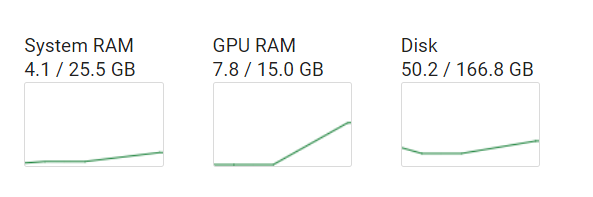

In [8]:
response = predict_function(data, models)

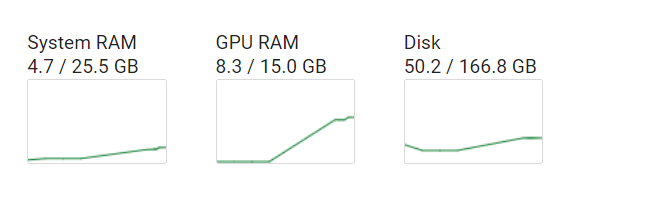

In [9]:
out = postprocess_function(response, content_type=None)
print(out)

{"response": "1. Calangute Beach - One of the most popular beaches in Goa, Calangute is known for its golden sands\nand clear waters. It's a great place to relax, sunbathe, or indulge in water sports like\nparasailing, jet skiing, and banana boat rides. 2. Anjuna Beach - Located on the west coast of Goa,\nAnjuna Beach is famous for its hippie culture and vibrant nightlife. You can enjoy live music\nperformances, dance parties, and beach bonfires at this beach. 3. Fort Aguada - Built by the\nPortuguese in 1610, Fort Aguada is one of the oldest forts in India. The fort offers stunning views\nof the Arabian Sea and is home to a lighthouse that dates back to the 1860s. 4. Dudhsagar Falls -\nLocated in the Western Ghats, Dudhsagar Falls is one of the tallest waterfalls in India. The falls\nare surrounded by lush green forests and offer a breathtaking view. 5. Basilica of Bom Jesus - A\nUNESCO World Heritage Site, the Basilica of Bom Jesus houses the remains of St. Francis Xavier, who\nwas b